In [146]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import itertools
datapath = "/Users/puyuange/Documents/uni stuff/Non-Trivial/NTFproject-Python/eudata/" 

In [147]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# SEIR model equations
def SEIR_model(y, t, beta, sigma, gamma):
    S, E, I, R = y
    dSdt = -beta * S * I
    dEdt = beta * S * I - sigma * E
    dIdt = sigma * E - gamma * I
    dRdt = gamma * I
    return [dSdt, dEdt, dIdt, dRdt]

# Initial conditions
def basic_SEIR_plot(axis):
    S0 = 1- 0.003 
    E0 = 0.003  
    I0 = 0.00  
    R0 = 0.00  
    y0 = [S0, E0, I0, R0]

    # Parameters
    beta = 0.1   
    sigma = 1/13   
    gamma = 1/21

    # Time vector
    t = np.linspace(0, 500, 500)  

    # Solve the SEIR model equations
    solution = odeint(SEIR_model, y0, t, args=(beta, sigma, gamma))

    # Extract results
    S, E, I, R = solution.T

    # Plot the results
    axis.plot(t, S, label='S', color="blue")
    axis.plot(t, E, label='e', color="orange")
    axis.plot(t, I, label='I', color="red")
    axis.plot(t, R, label='R', color="green")
    axis.set_xlabel('time (days)')
    axis.set_ylabel('proportion of population')
    axis.legend()

In [148]:
def id(node):
    return node[0]

def edge(matrix, fromnode, tonode): # Edge which flows i to j
    i = id(fromnode)
    i = int(i-1)
    j = id(tonode)
    j = int(j-1)
    return matrix[i][j]

#s, e, i and r
def N(node):
    return sum(node[1::])

def S(node):
    return node[1]

def E(node):
    return node[2]

def I(node):
    return node[3]

def R(node):
    return node[4]

def delta_seir(node, params_dict):
    
    beta = params_dict["beta"]
    c = params_dict["c"]
    sigma = params_dict["sigma"]
    gamma = params_dict["gamma"]

    dS = - ((beta * c) * S(node) * I(node)) / N(node)
    dE = ((beta * c) * S(node) * I(node)) / N(node) - sigma * E(node)
    dI = sigma * E(node) - gamma * I(node)
    dR = gamma * I(node)

    return np.array([0, dS, dE, dI, dR])

def delta_out(fromnode, tonode, flow_matrix, univ_matrix, partial_matrix):

    F = edge(flow_matrix, fromnode, tonode)
    U = edge(univ_matrix, fromnode, tonode)
    P = edge(partial_matrix, fromnode, tonode)

    FS = (U * S(fromnode) * F)/N(fromnode)
    FE = (U * E(fromnode) * F)/N(fromnode)
    FI = (U * P * I(fromnode) * F)/N(fromnode)
    FR = (U * R(fromnode) * F)/N(fromnode)

    return np.array([0, FS, FE, FI, FR])

def infected_enroute(fromnode, tonode, flow_matrix, freq_matrix, univ_matrix, partial_matrix, params_dict):
    
    A = params_dict["A"]
    beta = params_dict["beta"]
    r = params_dict["r"]

    F = edge(flow_matrix, fromnode, tonode)
    f = edge(freq_matrix, fromnode, tonode)
    U = edge(univ_matrix, fromnode, tonode)
    P = edge(partial_matrix, fromnode, tonode)

    s = (U * F * S(fromnode))/N(fromnode)
    i = (U * P * F * I(fromnode))/N(fromnode)

    L = s * (1-np.exp((-i * np.pi * np.square(r))/A)) * beta
    # later replace beta with 1-exp(-kT)
    
    delta_array = delta_out(fromnode, tonode, flow_matrix, univ_matrix, partial_matrix)
    
    delta_array[1] = delta_array[1] - L
    delta_array[2] = delta_array[2] + L

    return delta_array

def delta_travel(node, nodes, flow_matrix, freq_matrix, univ_matrix, partial_matrix, params_dict):
    intake = [0, 0, 0, 0, 0]
    outtake = [0, 0, 0, 0, 0]
    for n in [x for x in nodes if not (x==node).all()]:
        intake += infected_enroute(n, node, flow_matrix, freq_matrix, univ_matrix, partial_matrix, params_dict)
        outtake += delta_out(node, n, flow_matrix, univ_matrix, partial_matrix)
    return intake - outtake

def update_node_status(node, nodes, flow_matrix, freq_matrix, univ_matrix, partial_matrix, params_dict):
    node += delta_seir(node, params_dict)
    node += delta_travel(node, nodes, flow_matrix, freq_matrix, univ_matrix, partial_matrix, params_dict)
    return node


def sim(nodes, start, flow_matrix, freq_matrix, univ_matrix, partial_matrix, params_dict):
    t=start
    nodes_num = len(nodes)
    rowslist = []
    equilibrium = [False] * len(nodes)

    # Initial Values
    for i in range(0, nodes_num):
        initrow = [{"t": 0, "S": S(nodes[i]), "E": E(nodes[i]), "I": I(nodes[i]), "R":R(nodes[i])}]
        rowslist.append(initrow)


    #for t in range(1, time_horizon):
    while all(equilibrium) == False:
        t+=1
        for j in range(0, nodes_num):
            nodes[j] = update_node_status(nodes[j], nodes, flow_matrix, freq_matrix, univ_matrix, partial_matrix, params_dict)
            insertrow = {"t": t, "S": S(nodes[j]), "E": E(nodes[j]), "I": I(nodes[j]), "R":R(nodes[j])}
            rowslist[j].append(insertrow)
            diseased = (E(nodes[j]) + I(nodes[j]))/N(nodes[j])
            if diseased <= 0.005 and t>200:
                equilibrium[j] = True
    
    dflist = []
    for k in range(0, nodes_num):
        df = pd.DataFrame(rowslist[k])
        df["N"] = df["S"] + df["E"] + df["I"] + df["R"]
        df["C"] = df["I"] + df["R"]
        dflist.append(df)

    return dflist
    

def simuntil(nodes, until, flow_matrix, freq_matrix, univ_matrix, partial_matrix, params_dict):
    t=0
    nodes_num = len(nodes)
    rowslist = []

    # Initial Values
    for i in range(0, nodes_num):
        initrow = [{"t": 0, "S": S(nodes[i]), "E": E(nodes[i]), "I": I(nodes[i]), "R":R(nodes[i])}]
        rowslist.append(initrow)


    #for t in range(1, time_horizon):
    while t<until:
        t+=1
        for j in range(0, nodes_num):
            nodes[j] = update_node_status(nodes[j], nodes, flow_matrix, freq_matrix, univ_matrix, partial_matrix, params_dict)
            insertrow = {"t": t, "S": S(nodes[j]), "E": E(nodes[j]), "I": I(nodes[j]), "R":R(nodes[j])}
            rowslist[j].append(insertrow)
            diseased = (E(nodes[j]) + I(nodes[j]))/N(nodes[j])

    dflist = []

    for k in range(0, nodes_num):
        df = pd.DataFrame(rowslist[k])
        df["N"] = df["S"] + df["E"] + df["I"] + df["R"]
        df["C"] = df["I"] + df["R"]
        dflist.append(df)

    return dflist

def ESI(df_list, t_h):
    cumsum = 0
    sumpop = 0
    for df in df_list:
            cum = df.query("t == @t_h")["C"].item()
            cumsum += cum
            pop = df.query("t == @t_h")["N"].item()
            sumpop += pop


    return cumsum/sumpop

def disruption_constF(df_list, t_h, F_matrix, P_matrix, U_matrix): # constant flow rate
    total_flow = 0
    disrupted = 0

    lst = list(range(1, len(df_list) + 1))

    for i in lst:
        fromid = i-1
        df = df_list[fromid]

        exclu_lst = lst[:]
        exclu_lst.remove(i)


        for j in exclu_lst:
            toid = j-1
            F = F_matrix[fromid][toid]
            P = P_matrix[fromid][toid]
            U = U_matrix[fromid][toid]

            total_flow += F * t_h

            df["i"] = df.apply(lambda x: np.divide(x.I, x.N), axis=1)
            df["Irestrict"] = df["i"].apply(lambda x: F*(1-P*U)*x)
            df["otherrestrict"] = df["i"].apply(lambda x: F*(1-U)*(1-x))
            disrupted += df["Irestrict"].sum() + df["otherrestrict"].sum()

        df = None
    
    return disrupted/total_flow

def plot_SEIR(df, ax, title):
    ax.set_title(title, y=1.0, pad=-14)
    ax.plot(df["t"], df["S"], color="blue", label="S")
    ax.plot(df["t"], df["E"], color="orange", label="E")
    ax.plot(df["t"], df["I"], color="red", label="I")
    ax.plot(df["t"], df["R"], color="green", label="R")
    ax.plot(df["t"], df["C"], color="red", linestyle="dashed", label="C")
    ax.legend(loc="upper right")

def retrievenodes(dflist):
    nodes = []
    length = len(dflist)
    for i in range(0, length):
        df = dflist[i]
        node = np.array([i+1, df["S"].iloc[-1], df["E"].iloc[-1], df["I"].iloc[-1], df["R"].iloc[-1]]).astype(float)
        nodes.append(node)

    return nodes

def concat_dflists(dflist1, dflist2):
    return [pd.concat([a,b], axis=0, ignore_index=True) for a, b in zip(dflist1, dflist2)]



Countries selected are all part of the European Union \\

They are top 10 in population \\
1 - DE - Germany\\
2 - FR - France\\
3 - IT - Italy\\
4 - ES - Spain\\
5 - PL - Poland\\
6 - RO - Romania\\
7 - NL - Netherlands\\
8 - BE - Belgium\\
9 - SE - Sweden\\
10 - CZ - Czechia\\

Using travel data of last 10 years (2014-2023) to offset anomolous flight data from pandemic. Not too far back because air travel is continually increasing\\

ID used will be in alphabetical order of labels\\
1 - BE - Belgium\\
2 - CZ - Czechia\\
3 - DE - Germany\\
4 - ES - Spain\\
5 - FR - France\\
6 - IT - Italy\\
7 - NL - Netherlands\\
8 - PL - Poland\\
9 - RO - Romania\\
10 - SE - Sweden\\

Internal flights not considered

In [149]:
# Matrices

# Flow
flow_df = pd.read_csv(datapath + 'passenger-flow-intraEU.csv', sep=',', header=None)
flow_matrix = flow_df.values

# Frequency
freq_df = pd.read_csv(datapath + 'flight-freq-intraEU.csv', sep=',', header=None)
freq_matrix = freq_df.values

#Number
n_df = flow_df.combine(freq_df, lambda x, y: x/y)
n_matrix = n_df.values

#Restrictions
univ_matrix = np.array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],])

univdf = pd.DataFrame(univ_matrix)

partial_matrix = np.array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],])

partialdf = pd.DataFrame(partial_matrix)

In [150]:
#Paramters

params = {"beta": 1,
          "c": 0.1,
          "sigma": 1/13,
          "gamma": 1/21,
          "r": 1,
          "A": 100,}

In [151]:
# Nodes
BE = np.array([1, 11697557, 0, 0, 0]).astype(float)
CZ = np.array([2, 10850620, 0, 0, 0]).astype(float)
DE = np.array([3, 84607016, 0, 0, 0]).astype(float)
ES = np.array([4, 48797875, 0, 0, 0]).astype(float)
FR = np.array([5, 68410000, 0, 0, 0]).astype(float)
IT = np.array([6, 58968501, 0, 0, 0]).astype(float)
NL = np.array([7, 17938053, 0, 0, 0]).astype(float)
PL = np.array([8, 37595000, 0, 0, 0]).astype(float)
RO = np.array([9, 19053815, 0, 0, 0]).astype(float)
SE = np.array([10, 10548877, 1000, 0, 0]).astype(float)

nodes = [BE, CZ, DE, ES, FR, IT, NL, PL, RO, SE]

/var/folders/mp/gtpcl1p10z98ksbcwxz0n_pr0000gn/T/ipykernel_1664/3348640727.py:69: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(plt.cm.ScalarMappable(cmap=plt.cm.winter_r), label="Average Passengers per Plane [200 passengers]")
/var/folders/mp/gtpcl1p10z98ksbcwxz0n_pr0000gn/T/ipykernel_1664/3348640727.py:70: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(plt.cm.ScalarMappable(cmap=plt.cm.magma_r), label="Population [100 million people]")


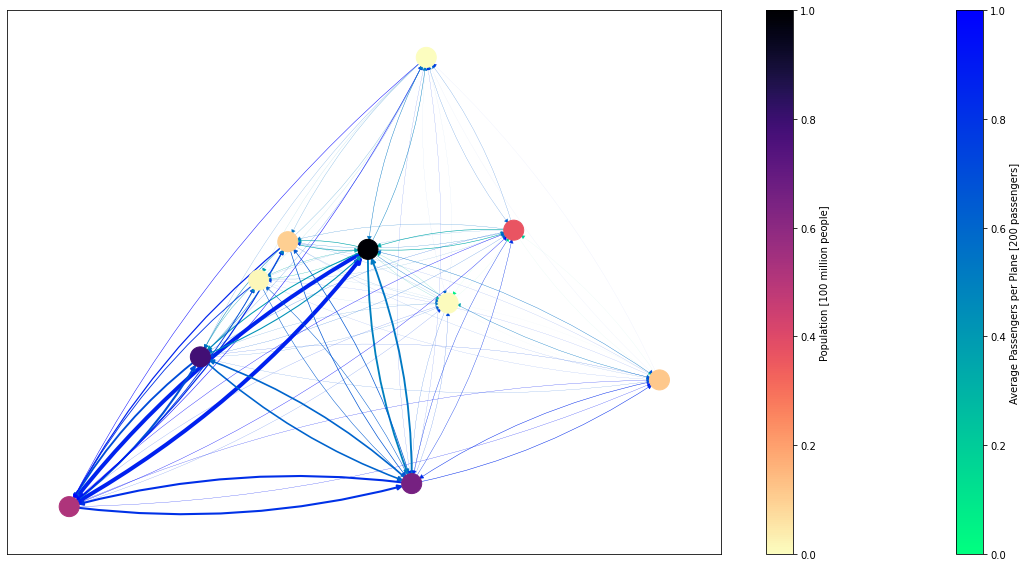

In [152]:
# Create a directed graph
G = nx.DiGraph()

plt.rcParams['figure.figsize'] = [20, 10]
length = len(nodes)
lst = list(range(1, length+1))
edges = []
widths = np.array([])
colours = np.array([])
node_colours = np.array([])
popmax = N(nodes[2])

for nd in nodes:
    pop = N(nd)
    normpop = pop/100000000
    node_colours = np.append(node_colours, normpop)

G.add_nodes_from(lst)

for i in lst:
    exclulist = lst[:]
    exclulist.remove(i)
    for j in exclulist:
        pair = (i,j)
        edges.append(pair)

        maxflow = np.max(flow_matrix)
        maxfreq = np.max(freq_matrix)
        maxn = np.max(n_matrix)

        normalised_flow = 4 * flow_matrix[i-1][j-1] / maxflow
        normalised_freq = freq_matrix[i-1][j-1] / maxfreq
        normalised_n = n_matrix[i-1][j-1] / 200

        widths = np.append(widths, normalised_flow)
        colours = np.append(colours, normalised_n)



G.add_edges_from(edges)


# Draw the graph
pos = {1: (-1.5, -0.8),
       2: (1.1, -1.4),
       3: (0,0),
       4: (-4.1, -6.7),
       5: (-2.3, -2.8),
       6: (0.6, -6.1),
       7: (-1.1, 0.2),
       8: (2, 0.5),
       9: (4, -3.4),
       10:(0.8, 5)}


nx.draw_networkx_nodes(G, pos,
                       node_color=node_colours,
                       node_size=400, 
                       cmap=plt.cm.magma_r)

nx.draw_networkx_edges(
    G, pos, 
    width=widths,
    edge_color=colours,
    edge_cmap=plt.cm.winter_r, 
    connectionstyle="arc3,rad=0.1"
)

plt.colorbar(plt.cm.ScalarMappable(cmap=plt.cm.winter_r), label="Average Passengers per Plane [200 passengers]")
plt.colorbar(plt.cm.ScalarMappable(cmap=plt.cm.magma_r), label="Population [100 million people]")
plt.savefig("europe-aviation-network.png", transparent=True)

In [153]:
# Sim
BE = np.array([1, 11697557, 0, 0, 0]).astype(float)
CZ = np.array([2, 10850620, 0, 0, 0]).astype(float)
DE = np.array([3, 84607016, 0, 0, 0]).astype(float)
ES = np.array([4, 48797875, 0, 0, 0]).astype(float)
FR = np.array([5, 68410000, 0, 0, 0]).astype(float)
IT = np.array([6, 58968501, 0, 0, 0]).astype(float)
NL = np.array([7, 17938053, 0, 0, 0]).astype(float)
PL = np.array([8, 37595000, 0, 0, 0]).astype(float)
RO = np.array([9, 19053815, 0, 0, 0]).astype(float)
SE = np.array([10, 10548877, 1000, 0, 0]).astype(float)

nodes = [BE, CZ, DE, ES, FR, IT, NL, PL, RO, SE]

t_R = 0
univ_matrix = np.array([[1 for col in range(10)] for row in range(10)])
partial_matrix = np.array([[1 for col in range(10)] for row in range(10)])
dflist1 = simuntil(nodes, t_R, flow_matrix, freq_matrix, univ_matrix, partial_matrix, params)
newnodes = retrievenodes(dflist1)

univ_matrix = np.array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
                        [1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
                        [1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
                        [1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
                        [1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
                        [1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
                        [1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
                        [1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
                        [1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
                        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
univ_matrix = np.array([[1 for col in range(10)] for row in range(10)])

partial_matrix = np.array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
                           [1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
                           [1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
                           [1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
                           [1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
                           [1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
                           [1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
                           [1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
                           [1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
                           [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
partial_matrix = np.array([[1 for col in range(10)] for row in range(10)])


dflist2 = sim(newnodes, t_R, flow_matrix, freq_matrix, univ_matrix, partial_matrix, params)
dflist = concat_dflists(dflist1, dflist2)

In [154]:
T = dflist[0]["t"].max()
print(T)
print(ESI(dflist, T))
print(disruption_constF(dflist, T, flow_matrix, partial_matrix, univ_matrix))

492
0.8887825189898149
0.0


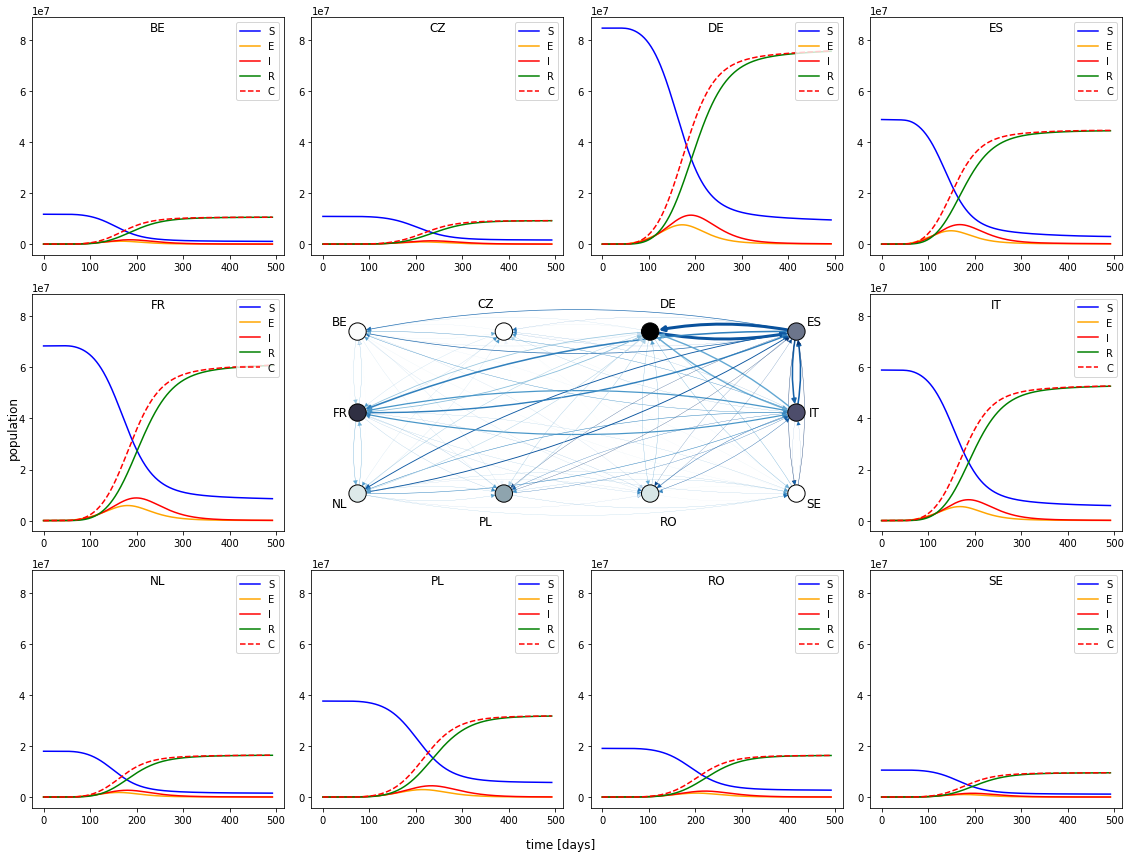

In [155]:
# Multiplot graph with SEIR

# setup:
fig = plt.figure()
fig.set_figheight(12)
fig.set_figwidth(16)

axnet = plt.subplot2grid(shape=(3, 4), loc=(1, 1), colspan=2, rowspan=1)

ax3 = plt.subplot2grid(shape=(3, 4), loc=(0, 2), colspan=1, rowspan=1)

ax1 = plt.subplot2grid(shape=(3, 4), loc=(0, 0), colspan=1, rowspan=1, sharex=ax3, sharey=ax3)
ax2 = plt.subplot2grid(shape=(3, 4), loc=(0, 1), colspan=1, rowspan=1, sharex=ax3, sharey=ax3)
ax4 = plt.subplot2grid(shape=(3, 4), loc=(0, 3), colspan=1, rowspan=1, sharex=ax3, sharey=ax3)
ax5 = plt.subplot2grid(shape=(3, 4), loc=(1, 0), colspan=1, rowspan=1, sharex=ax3, sharey=ax3)
ax6 = plt.subplot2grid(shape=(3, 4), loc=(1, 3), colspan=1, rowspan=1, sharex=ax3, sharey=ax3)
ax7 = plt.subplot2grid(shape=(3, 4), loc=(2, 0), colspan=1, rowspan=1, sharex=ax3, sharey=ax3)
ax8 = plt.subplot2grid(shape=(3, 4), loc=(2, 1), colspan=1, rowspan=1, sharex=ax3, sharey=ax3)
ax9 = plt.subplot2grid(shape=(3, 4), loc=(2, 2), colspan=1, rowspan=1, sharex=ax3, sharey=ax3)
ax10 = plt.subplot2grid(shape=(3, 4), loc=(2, 3), colspan=1, rowspan=1, sharex=ax3, sharey=ax3)

#Network
G = nx.DiGraph()
length = len(nodes)
lst = list(range(1, length+1))
edges = []
widths = np.array([])
colours = np.array([])
node_colours = np.array([])
popmax = N(nodes[2])

for nd in nodes:
    pop = N(nd)
    normpop = pop/100000000
    node_colours = np.append(node_colours, normpop)

G.add_nodes_from(lst)

for i in lst:
    exclulist = lst[:]
    exclulist.remove(i)
    for j in exclulist:
        pair = (i,j)
        edges.append(pair)

        u = univ_matrix[i-1][j-1]

        maxflow = np.max(flow_matrix)
        maxfreq = np.max(freq_matrix)
        maxn = np.max(n_matrix)

        normalised_flow = u * 3 * flow_matrix[i-1][j-1] / maxflow
        normalised_freq = freq_matrix[i-1][j-1] / maxfreq
        normalised_n = n_matrix[i-1][j-1] / 200

        widths = np.append(widths, normalised_flow)
        colours = np.append(colours, normalised_n)

G.add_edges_from(edges)

pos = {1: (-1.5, 1),
       2: (-0.5, 1),
       3: (0.5, 1),
       4: (1.5, 1),
       5: (-1.5, 0),
       6: (1.5, 0),
       7: (-1.5, -1),
       8: (-0.5, -1),
       9: (0.5, -1),
       10:(1.5, -1)}

label_pos = {1: (-1.62, 1.12),
             2: (-0.625, 1.35),
             3: (0.625, 1.35),
             4: (1.62, 1.12),
             5: (-1.62, 0),
             6: (1.62, 0),
             7: (-1.62, -1.12),
             8: (-0.625, -1.35),
             9: (0.625, -1.35),
             10:(1.62, -1.12)}

labls={1: "BE", 2:"CZ", 3:"DE", 4:"ES", 5:"FR", 6:"IT", 7:"NL", 8:"PL", 9:"RO", 10:"SE"}
nx.draw_networkx_nodes(G, pos, node_color=node_colours, node_size=300, cmap=plt.cm.bone_r, ax=axnet, linewidths=1, edgecolors="black")
nx.draw_networkx_edges(G, pos, width=widths,edge_color=colours, edge_cmap=plt.cm.Blues, connectionstyle="arc3,rad=0.1", ax=axnet)
nx.draw_networkx_labels(G, label_pos, labels=labls, font_size=12, font_color='black', ax=axnet)

axnet.spines['top'].set_visible(False)
axnet.spines['right'].set_visible(False)
axnet.spines['bottom'].set_visible(False)
axnet.spines['left'].set_visible(False)

#SEIR
plot_SEIR(dflist[0], ax1, "BE")
plot_SEIR(dflist[1], ax2, "CZ")
plot_SEIR(dflist[2], ax3, "DE")
plot_SEIR(dflist[3], ax4, "ES")
plot_SEIR(dflist[4], ax5, "FR")
plot_SEIR(dflist[5], ax6, "IT")
plot_SEIR(dflist[6], ax7, "NL")
plot_SEIR(dflist[7], ax8, "PL")
plot_SEIR(dflist[8], ax9, "RO")
plot_SEIR(dflist[9], ax10, "SE")

fig.supxlabel('time [days]')
fig.supylabel('population')

plt.tight_layout()
plt.show()

In [156]:
dflist[0].head()

,t,S,E,I,R,N,C,i,Irestrict,otherrestrict
0,0,1.169756e+07,0.000000,0.000000,0.000000,1.169756e+07,0.000000,0.000000e+00,0.0,0.0
1,0,1.169756e+07,0.000000,0.000000,0.000000,1.169756e+07,0.000000,0.000000e+00,0.0,0.0
2,1,1.169738e+07,0.056682,0.000000,0.000000,1.169738e+07,0.000000,0.000000e+00,0.0,0.0
3,2,1.169721e+07,0.186361,0.008708,0.000000,1.169721e+07,0.008708,7.444288e-10,0.0,0.0
4,3,1.169703e+07,0.377175,0.030761,0.000621,1.169703e+07,0.031382,2.629786e-09,0.0,0.0


In [157]:
# Plot total:
def totaldf(dflist):
    bigdf = pd.DataFrame(columns=['t', 'S', 'E', 'I', 'R', 'C', 'N'])
    bigdf["t"] = dflist[0]["t"]
    for dummy in dflist:
        bigdf["S"] = bigdf["S"].add(dummy["S"], fill_value=0)
        bigdf["E"] = bigdf["E"].add(dummy["E"], fill_value=0)
        bigdf["I"] = bigdf["I"].add(dummy["I"], fill_value=0)
        bigdf["R"] = bigdf["R"].add(dummy["R"], fill_value=0)
        bigdf["C"] = bigdf["C"].add(dummy["C"], fill_value=0)
        bigdf["N"] = bigdf["N"].add(dummy["N"], fill_value=0)
    return bigdf

In [158]:
# Sim
BE = np.array([1, 11697557, 0, 0, 0]).astype(float)
CZ = np.array([2, 10850620, 0, 0, 0]).astype(float)
DE = np.array([3, 84607016, 0, 0, 0]).astype(float)
ES = np.array([4, 48797875, 0, 0, 0]).astype(float)
FR = np.array([5, 68410000, 0, 0, 0]).astype(float)
IT = np.array([6, 58968501, 0, 0, 0]).astype(float)
NL = np.array([7, 17938053, 0, 0, 0]).astype(float)
PL = np.array([8, 37595000, 0, 0, 0]).astype(float)
RO = np.array([9, 19053815, 0, 0, 0]).astype(float)
SE = np.array([10, 10548877, 1000, 0, 0]).astype(float)
nodes = [BE, CZ, DE, ES, FR, IT, NL, PL, RO, SE]
univ_matrix = np.array([[1 for col in range(10)] for row in range(10)])
partial_matrix = np.array([[1 for col in range(10)] for row in range(10)])


dflist0 = sim(nodes, 0, flow_matrix, freq_matrix, univ_matrix, partial_matrix, params)

BE = np.array([1, 11697557, 0, 0, 0]).astype(float)
CZ = np.array([2, 10850620, 0, 0, 0]).astype(float)
DE = np.array([3, 84607016, 0, 0, 0]).astype(float)
ES = np.array([4, 48797875, 0, 0, 0]).astype(float)
FR = np.array([5, 68410000, 0, 0, 0]).astype(float)
IT = np.array([6, 58968501, 0, 0, 0]).astype(float)
NL = np.array([7, 17938053, 0, 0, 0]).astype(float)
PL = np.array([8, 37595000, 0, 0, 0]).astype(float)
RO = np.array([9, 19053815, 0, 0, 0]).astype(float)
SE = np.array([10, 10548877, 1000, 0, 0]).astype(float)

nodes = [BE, CZ, DE, ES, FR, IT, NL, PL, RO, SE]
univ_matrix = np.array([[1 for col in range(10)] for row in range(10)])
partial_matrix = np.array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                           [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                           [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                           [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                           [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                           [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                           [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                           [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                           [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                           [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
dflist1 = sim(nodes, 0, flow_matrix, freq_matrix, univ_matrix, partial_matrix, params)

BE = np.array([1, 11697557, 0, 0, 0]).astype(float)
CZ = np.array([2, 10850620, 0, 0, 0]).astype(float)
DE = np.array([3, 84607016, 0, 0, 0]).astype(float)
ES = np.array([4, 48797875, 0, 0, 0]).astype(float)
FR = np.array([5, 68410000, 0, 0, 0]).astype(float)
IT = np.array([6, 58968501, 0, 0, 0]).astype(float)
NL = np.array([7, 17938053, 0, 0, 0]).astype(float)
PL = np.array([8, 37595000, 0, 0, 0]).astype(float)
RO = np.array([9, 19053815, 0, 0, 0]).astype(float)
SE = np.array([10, 10548877, 1000, 0, 0]).astype(float)

nodes = [BE, CZ, DE, ES, FR, IT, NL, PL, RO, SE]
univ_matrix = np.array([[1 for col in range(10)] for row in range(10)])
partial_matrix = np.array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
                           [1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
                           [1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
                           [1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
                           [1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
                           [1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
                           [1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
                           [1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
                           [1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
                           [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
dflist2 = sim(nodes, 0, flow_matrix, freq_matrix, univ_matrix, partial_matrix, params)


BE = np.array([1, 11697557, 0, 0, 0]).astype(float)
CZ = np.array([2, 10850620, 0, 0, 0]).astype(float)
DE = np.array([3, 84607016, 0, 0, 0]).astype(float)
ES = np.array([4, 48797875, 0, 0, 0]).astype(float)
FR = np.array([5, 68410000, 0, 0, 0]).astype(float)
IT = np.array([6, 58968501, 0, 0, 0]).astype(float)
NL = np.array([7, 17938053, 0, 0, 0]).astype(float)
PL = np.array([8, 37595000, 0, 0, 0]).astype(float)
RO = np.array([9, 19053815, 0, 0, 0]).astype(float)
SE = np.array([10, 10548877, 1000, 0, 0]).astype(float)

nodes = [BE, CZ, DE, ES, FR, IT, NL, PL, RO, SE]
univ_matrix = np.array([[1 for col in range(10)] for row in range(10)])
partial_matrix = np.array([[0 for col in range(10)] for row in range(10)])
dflist3 = sim(nodes, 0, flow_matrix, freq_matrix, univ_matrix, partial_matrix, params)


BE = np.array([1, 11697557, 0, 0, 0]).astype(float)
CZ = np.array([2, 10850620, 0, 0, 0]).astype(float)
DE = np.array([3, 84607016, 0, 0, 0]).astype(float)
ES = np.array([4, 48797875, 0, 0, 0]).astype(float)
FR = np.array([5, 68410000, 0, 0, 0]).astype(float)
IT = np.array([6, 58968501, 0, 0, 0]).astype(float)
NL = np.array([7, 17938053, 0, 0, 0]).astype(float)
PL = np.array([8, 37595000, 0, 0, 0]).astype(float)
RO = np.array([9, 19053815, 0, 0, 0]).astype(float)
SE = np.array([10, 10548877, 1000, 0, 0]).astype(float)

nodes = [BE, CZ, DE, ES, FR, IT, NL, PL, RO, SE]
univ_matrix = np.array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
partial_matrix = np.array([[1 for col in range(10)] for row in range(10)])
dflist4 = sim(nodes, 0, flow_matrix, freq_matrix, univ_matrix, partial_matrix, params)


BE = np.array([1, 11697557, 0, 0, 0]).astype(float)
CZ = np.array([2, 10850620, 0, 0, 0]).astype(float)
DE = np.array([3, 84607016, 0, 0, 0]).astype(float)
ES = np.array([4, 48797875, 0, 0, 0]).astype(float)
FR = np.array([5, 68410000, 0, 0, 0]).astype(float)
IT = np.array([6, 58968501, 0, 0, 0]).astype(float)
NL = np.array([7, 17938053, 0, 0, 0]).astype(float)
PL = np.array([8, 37595000, 0, 0, 0]).astype(float)
RO = np.array([9, 19053815, 0, 0, 0]).astype(float)
SE = np.array([10, 10548877, 1000, 0, 0]).astype(float)

nodes = [BE, CZ, DE, ES, FR, IT, NL, PL, RO, SE]
univ_matrix = np.array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
                        [1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
                        [1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
                        [1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
                        [1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
                        [1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
                        [1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
                        [1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
                        [1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
                        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
partial_matrix = np.array([[1 for col in range(10)] for row in range(10)])
dflist5 = sim(nodes, 0, flow_matrix, freq_matrix, univ_matrix, partial_matrix, params)


BE = np.array([1, 11697557, 0, 0, 0]).astype(float)
CZ = np.array([2, 10850620, 0, 0, 0]).astype(float)
DE = np.array([3, 84607016, 0, 0, 0]).astype(float)
ES = np.array([4, 48797875, 0, 0, 0]).astype(float)
FR = np.array([5, 68410000, 0, 0, 0]).astype(float)
IT = np.array([6, 58968501, 0, 0, 0]).astype(float)
NL = np.array([7, 17938053, 0, 0, 0]).astype(float)
PL = np.array([8, 37595000, 0, 0, 0]).astype(float)
RO = np.array([9, 19053815, 0, 0, 0]).astype(float)
SE = np.array([10, 10548877, 1000, 0, 0]).astype(float)

nodes = [BE, CZ, DE, ES, FR, IT, NL, PL, RO, SE]
univ_matrix = np.array([[0 for col in range(10)] for row in range(10)])
partial_matrix = np.array([[1 for col in range(10)] for row in range(10)])
dflist6 = sim(nodes, 0, flow_matrix, freq_matrix, univ_matrix, partial_matrix, params)

In [159]:
df0=totaldf(dflist0)
df1=totaldf(dflist1)
df2=totaldf(dflist2)
df3=totaldf(dflist3)
df4=totaldf(dflist4)
df5=totaldf(dflist5)
df6=totaldf(dflist6)

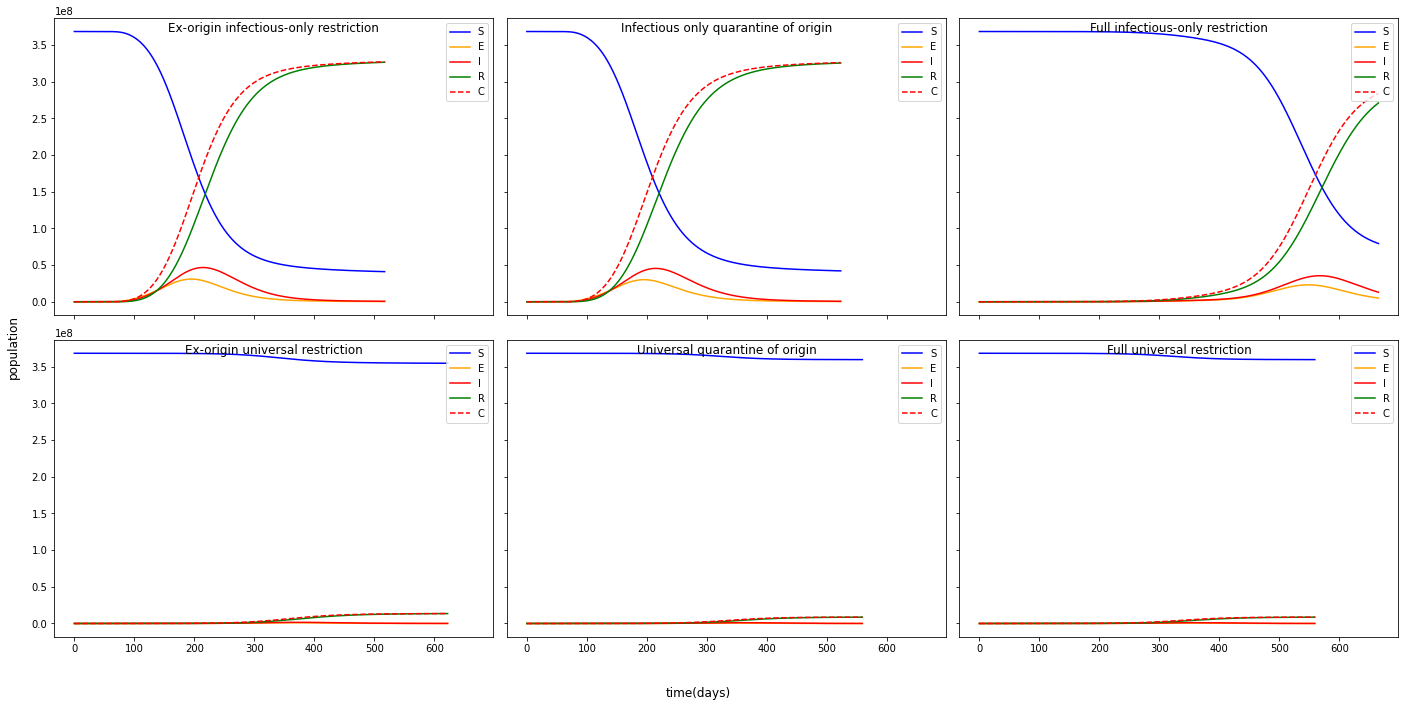

In [173]:
fig, axs = plt.subplots(2, 3, sharex=True, sharey=True)
plot_SEIR(df1, axs[0,0], "Ex-origin infectious-only restriction")
plot_SEIR(df2, axs[0,1], "Infectious only quarantine of origin")
plot_SEIR(df3, axs[0,2], "Full infectious-only restriction")
plot_SEIR(df4, axs[1,0], "Ex-origin universal restriction")
plot_SEIR(df5, axs[1,1], "Universal quarantine of origin")
plot_SEIR(df6, axs[1,2], "Full universal restriction")
fig.supxlabel("time(days)")
fig.supylabel("population")

plt.tight_layout(pad=2, w_pad=1, h_pad=1.0)